In [55]:
# Move imports to utility
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, gc, random, math 
from pathlib import Path
from tqdm.notebook import tqdm
import IPython.display as ipd
from IPython.display import display, clear_output
import ipywidgets as widgets

import librosa
import librosa.display
import soundfile as sf

import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, average_precision_score
from sklearn.preprocessing import LabelEncoder

NOTE
- See if imports, along with preprocessingg and augmentation funcs can easily be moved to the utility folder


In [2]:
class Config:
    SEED = 42
    SAMPLE_RATE = 32000
    DATA_PATH = Path("/kaggle/input/birdclef-2025")
    # Spectrogram Params
    N_MELS = 128
    N_FFT = 2048
    HOP_LENGTH = 512
    FMIN = 50
    FMAX = 14000
    # Clip params (setting for 5s to align with submission policy)
    TARGET_DURATION_S = 5
    TARGET_SAMPLES = TARGET_DURATION_S * SAMPLE_RATE
    # Path for training audio
    TRAIN_AUDIO_PATH = DATA_PATH/"train_audio"
    TRAIN_METADATA_PATH = DATA_PATH/"train.csv"
    TAXONOMY_PATH = DATA_PATH/"taxonomy.csv"
    # additional paths here
    #TRAIN_SOUNDSCAPES_PATH = DATA_PATH/"train_soundscapes"
    #TEST_SOUNDSCAPES_PATH = DATA_PATH/"test_soundscapes"    

In [3]:
# Function to seed everything to ensure reproducibility
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # Change to true if input sizes are kept constant

In [4]:
# Setup 
cfg = Config()
seed_everything(cfg.SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [5]:
# Loading Taxonomy data for context
if cfg.TAXONOMY_PATH.exists():
    taxonomy_df = pd.read_csv(cfg.TAXONOMY_PATH)
    print("Taxonomy data loaded")
    print(taxonomy_df.head())
    print("\nClass distribution across taxa: ")
    print(taxonomy_df['class_name'].value_counts())
else:
    print(f"File not found at {cfg.TAXONOMY_PATH}")

Taxonomy data loaded
  primary_label  inat_taxon_id               scientific_name  \
0       1139490        1139490          Ragoniella pulchella   
1       1192948        1192948         Oxyprora surinamensis   
2       1194042        1194042           Copiphora colombiae   
3        126247         126247       Leptodactylus insularum   
4       1346504        1346504  Neoconocephalus brachypterus   

                    common_name class_name  
0          Ragoniella pulchella    Insecta  
1         Oxyprora surinamensis    Insecta  
2           Copiphora colombiae    Insecta  
3        Spotted Foam-nest Frog   Amphibia  
4  Neoconocephalus brachypterus    Insecta  

Class distribution across taxa: 
class_name
Aves        146
Amphibia     34
Insecta      17
Mammalia      9
Name: count, dtype: int64


Move to the utility file once this is tested

In [6]:
# Load the training data
train_df = pd.read_csv(cfg.DATA_PATH/"train.csv")

In [7]:
# MOVE TO UTILS
# As before, create column for durations 
if 'train_df' in globals() and not train_df.empty:
    print("Analyzing audio durations...")
    durations = []
    pbar = tqdm(train_df['filename'].tolist(), desc="Calculating durations")
    for filename in pbar:
        file_path = cfg.DATA_PATH/"train_audio"/filename
        if file_path.exists():
            try:
                # Efficient approach to get duration with loading the whole file
                info = sf.info(file_path)
                durations.append(info.duration)
            except Exception as e:
                print(f"Could not get info for {filename}: {e}") #Comment / uncomment for debugging
                durations.append(np.nan) # mark errors
        else:
            durations.append(np.nan)

Analyzing audio durations...


Calculating durations:   0%|          | 0/28564 [00:00<?, ?it/s]

In [8]:
train_df['duration'] = durations
train_df['duration'].describe()

count    28564.000000
mean        35.352463
std         50.605646
min          0.544594
25%         10.579445
50%         20.976312
75%         41.300031
max       1774.392000
Name: duration, dtype: float64

In [9]:
# Carry out Mel Spectrogram transforms
mel_spectrogram_tfms = T.MelSpectrogram(
    sample_rate = cfg.SAMPLE_RATE,
    n_fft = cfg.N_FFT,
    hop_length = cfg.HOP_LENGTH,
    n_mels = cfg.N_MELS,
    f_min = cfg.FMIN,
    f_max = cfg.FMAX
).to(device) # transforms are moved to the GPU

In [10]:
# Connverty power spec to DB
amp_to_db_tfms = T.AmplitudeToDB(stype='power', top_db=80).to(device) 

In [11]:
# Another one for the utility file
# Then clean up
def preprocess_audio_file(file_path: Path, target_sr=cfg.SAMPLE_RATE,
                          target_samples=cfg.TARGET_SAMPLES):
    """Loads an audio file, resamples, splits into 5s non-overlapping clips,
    and converts each clip to a Mel spectrogram tensor."""
    spectrograms = []
    try: 
        waveform, sr = torchaudio.load(file_path) #return tensor [channels, time]
        # Resample if needed
        if sr != target_sr:
            resampler = T.Resample(sr, target_sr).to(waveform.device)
            waveform = resampler(waveform)
        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        # Ensure waveform is on the correct device
        waveform = waveform.to(device)
        # Calculate number of full clips
        num_samples = waveform.shape[1]
        num_clips = num_samples // target_samples

        for i in range(num_clips):
            start_sample = i * target_samples
            end_sample = start_sample + target_samples
            clip = waveform[:, start_sample:end_sample] # Keep channel dim for tfms
            # Generate Mel spectrogram with output [channel, n_mels, time]
            mel_spec = mel_spectrogram_tfms(clip) 
            # Convert to DB scale
            mel_spec_db = amp_to_db_tfms(mel_spec)
            # Squeeze channel dims -> [n_mels, time]
            spectrograms.append(mel_spec_db.squeeze(0))

        # If we want to use the remaining samples for training, then this section can be uncommented:
        # remaining_samples = num_samples % target_samples
        # if remaining_samples > 0 and end_behavior=='pad': # Example
        #    last_clip = waveform[:, num_full_clips*target_samples:]
        #    padding = target_samples - last_clip.shape[1]
        #    last_clip_padded = torch.nn.functional.pad(last_clip, (0, padding))
    except Exception as e:
        print(f"Error processing {file_path.name}: {e}")
        # return empty list on error
        return []
    return spectrograms


Preprocessing test file: 1139490/CSA36385.ogg (Label: 1139490)
Expected duration: 98.85s
Successfully generated 19 spectrogram clips.
Shape of first spectrogram tensor: torch.Size([128, 313])
Device of spectrogram tensor: cuda:0


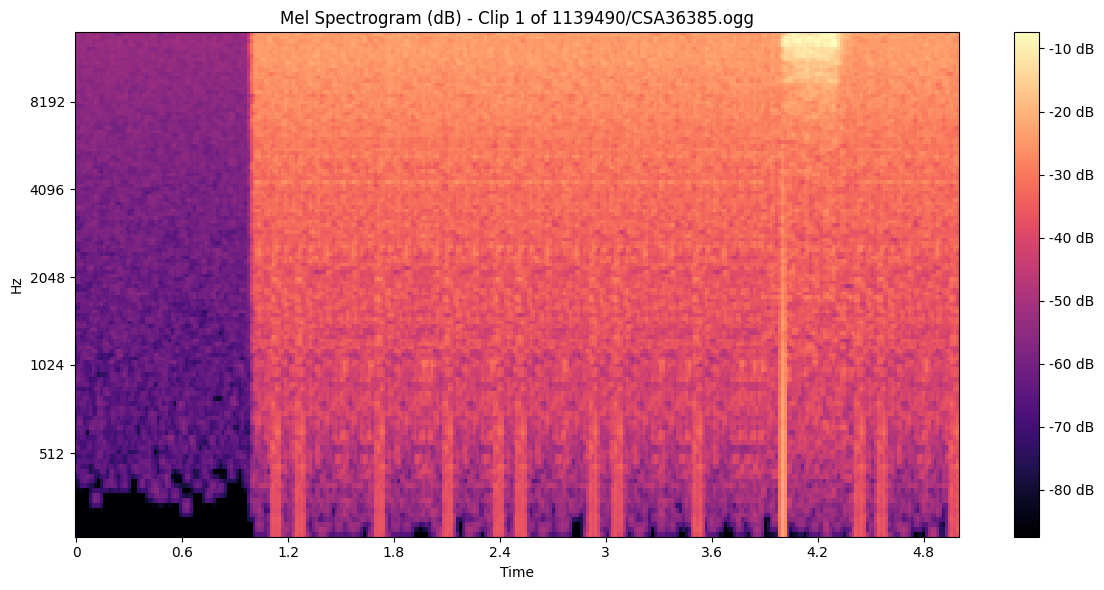

In [12]:
# Test the above function on one sample
if 'train_df' in globals() and not train_df.empty:
    # Take the first file longer than 6 seconds
    test = train_df[train_df['duration'] > 6].iloc[0]
    test_fn = test['filename']
    test_lbl = test['primary_label']
    test_path = cfg.TRAIN_AUDIO_PATH / test_fn

    print(f"\nPreprocessing test file: {test_fn} (Label: {test_lbl})")
    print(f"Expected duration: {test['duration']:.2f}s")

    if test_path.exists():
        specs = preprocess_audio_file(test_path)

        if specs:
            print(f"Successfully generated {len(specs)} spectrogram clips.")
            print(f"Shape of first spectrogram tensor: {specs[0].shape}")
            print(f"Device of spectrogram tensor: {specs[0].device}")
            # Visualize the spectrogram clip and move to CPU for plotting 
            plt.figure(figsize=(12, 6))
            spec_plt = specs[0].cpu().numpy()
            librosa.display.specshow(spec_plt, sr=cfg.SAMPLE_RATE, hop_length=cfg.HOP_LENGTH,
                                     x_axis='time', y_axis='mel', fmin=cfg.FMIN, fmax=cfg.FMAX)
            plt.colorbar(format='%+2.0f dB')
            plt.title(f"Mel Spectrogram (dB) - Clip 1 of {test_fn}")
            plt.tight_layout()
            plt.show()
        else: print("Preprocessing failed or file too short.")
    else: print(f"Test file not found: {test_path}")
else: print("train_df not available for test.")
        

Testing the `preprocess_audio_file()` function on a single sample returns 19 spectrogram clips of 5 seconds each.

Additionally, the output `torch.Size([128, 313])` confirms the Mel Spectrogram dimensions `(N_MELS=128)` and the calculated time steps for a 5 second clip with the parameters already set at the start of the NB results in `floor(16000/512) + 1 = 313 frames`. So things appear to be consistent.

The next step involves creating our core pipeline before setting up the dataloaders.

## Core Pipeline - Building a Dataset Class

Before creating a dataloader, we'll need to define a `Dataset` class that loads audio and uses the `preprocess_audio_clips` function to return pairs of spectrograms and labels which are mapped consistently.

As a first step, lets create a label encoder which maps string labels to integer indices (0-205) and back. A target label vector, in multi-label binary format, will also be needed.

In [13]:
# Create label encoder
if not train_df.empty and 'primary_label' in train_df.columns:
    u_lbl = sorted(train_df['primary_label'].unique())
    n_class = len(u_lbl)
    print(f"Found {n_class} unique primary labels.")

    # Mappings from label strings to int index and back
    lbl_2_int = {l: i for i, l in enumerate(u_lbl)}
    int_2_lbl = {i: l for l, i in lbl_2_int.items()}
    # Adding int labels to the df 
    train_df['primary_label_int'] = train_df['primary_label'].map(lbl_2_int)
    # Storing mappings in config for global access
    cfg.N_CLASSES = n_class
    cfg.LBL_2_INT = lbl_2_int
    cfg.INT_2_LBL = int_2_lbl
else: 
     print("train_df is empty or missing 'primary label'. Cannot create encoder.")
     cfg.N_CLASSES = 0     

Found 206 unique primary labels.


In [14]:
# Test look up and reverse lookup
print("Example label mappings:")
print(f"    'socfly1' -> {lbl_2_int.get('socfly1', 'Not Found')}")
print(f"    'Index 164'-> {int_2_lbl.get(164, 'Not Found')}")

Example label mappings:
    'socfly1' -> 164
    'Index 164'-> socfly1


In [15]:
# Helped function for creating the target tensor
def create_target_tensor(pri_lbl_int, n_classes):
    """Creates a multi label binary tensor for a given primary label"""
    t = torch.zeros(n_classes, dtype=torch.float32)
    if pri_lbl_int is not None and 0 <= pri_lbl_int < n_classes:
        t[pri_lbl_int] = 1.0
    return t

In [16]:
# Test the helper function
if cfg.N_CLASSES > 0:
  ex_lbl_int = lbl_2_int.get('socfly1') # Use a known label
  if ex_lbl_int is not None:
      ex_tgt = create_target_tensor(ex_lbl_int, cfg.N_CLASSES)
      print("\nExample target tensor for 'socfly1':")
      print(f"  Shape: {ex_tgt.shape}")
      print(f"  Sum (should be 1.0): {ex_tgt.sum()}")
      print(f"  Index of 1: {torch.argmax(ex_tgt)}") 
      print(ex_tgt) # Uncomment to see the full tensor
  else:
      print("Could not find 'socfly1' in label mapping for testing.")


Example target tensor for 'socfly1':
  Shape: torch.Size([206])
  Sum (should be 1.0): 1.0
  Index of 1: 164
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.

We will predetermine how many 5 second clips each valid audio file contains. This info can be stored to calculate the total dataset size, followed by index level mapping.

In [ ]:
# Store in config
cfg.TOTAL_CLIPS = c_total

In [ ]:
clip_df.info()

In [ ]:
clip_df['primary_label_int'].hist(bins=25);

In [ ]:
clip_df['primary_label_int'].describe()

In [ ]:
clip_df['clip_index'].hist(bins=25);

In [ ]:
clip_df['clip_index'].describe()

In [ ]:
# Testing the dataset class
if cfg.TOTAL_CLIPS > 0:
    bird_data = BirdClefDS(c_samples, cfg.TRAIN_AUDIO_PATH, cfg.N_CLASSES)

    print(f"\nCreated dataset with {len(bird_data)} samples.")

    # get a few items
    n_test_items = 5
    for i in range(n_test_items):
        idx = random.randint(0, len(bird_data) - 1)
        print(f"\nTesting __getitem__ with index: {idx}")
        spec, tgt = bird_data[idx]

        if spec is not None and tgt is not None:
            print(f"     Spectrogram shape: {spec.shape}")
            print(f"     Spectrogram device: {spec.device}")
            print(f"     Target shape: {tgt.shape}")
            print(f"     Target sum (check for 1.0): {tgt.sum()}")
            lbl_idx = torch.argmax(tgt).item()
            print(f"     Target label index: {lbl_idx}")
            print(f"     Mapped back to label: {cfg.INT_2_LBL.get(lbl_idx, 'Unknown')}")
            # Plot a test spectrogram
            if i == 0:
                plt.figure(figsize=(12, 6))
                librosa.display.specshow(spec.cpu().numpy(), sr=cfg.SAMPLE_RATE,
                                         hop_length=cfg.HOP_LENGTH,
                                         x_axis='time', y_axis='mel',
                                         fmin=cfg.FMIN, fmax=cfg.FMAX)
                plt.colorbar(format='%+2.0f dB')
                plt.title(f"Spectrogram from Dataset (Index: {idx}, Label: {cfg.INT_2_LBL.get(lbl_idx)})")
                plt.tight_layout()
                plt.show()
        else: print(f"     Failed to retrieve item at index {idx}.")
else: print(f"\nCannot create or test dataset because no clips were loaded / calculated.")
    

- `create_target_tensor` outputs match expectations i.e.tensor of size 206, sum 1.0 and 1.0 at the indexes.
- Clip calculations align wih earlier duration analysis.
- The _Error processing clip_ output is what we need to focus on. Could this be because of torchaudio's backend processing, or something in how we're handling durations?

## DEBUGGING 

#### (Letting the LLM handle diagnostics and debugging)

In [ ]:
# --- Debugging the problematic file ---
problem_filename = "ywcpar/iNat922688.ogg" # File causing issues
problem_filepath = cfg.TRAIN_AUDIO_PATH / problem_filename

print(f"\n--- Debugging file: {problem_filepath} ---")

# 1. Check if the file exists
print(f"File exists: {problem_filepath.exists()}")

if problem_filepath.exists():
    # 2. Try getting info using torchaudio
    try:
        info = torchaudio.info(problem_filepath)
        print("\nTorchaudio Info:")
        print(info)
    except Exception as e:
        print(f"\nError getting torchaudio.info: {e}")

    # 3. Try getting info using soundfile (often used by librosa)
    try:
        info_sf = sf.info(problem_filepath)
        print("\nSoundfile Info:")
        print(info_sf)
    except Exception as e:
        print(f"\nError getting soundfile.info: {e}")


    # 4. Try loading the *entire* file with torchaudio
    print("\nAttempting torchaudio.load (full file)...")
    try:
        waveform_full, sr_full = torchaudio.load(problem_filepath)
        print(f"  Success! Shape: {waveform_full.shape}, Sample Rate: {sr_full}")
        del waveform_full # Free memory
        gc.collect()
    except Exception as e:
        print(f"  FAILED to load full file with torchaudio: {e}")


    # 5. Try loading the *entire* file with librosa
    print("\nAttempting librosa.load (full file)...")
    try:
        # Librosa uses soundfile by default for ogg, might work if torchaudio fails
        waveform_lib, sr_lib = librosa.load(problem_filepath, sr=None) # Load native sr
        print(f"  Success! Shape: {waveform_lib.shape}, Sample Rate: {sr_lib}")
        del waveform_lib # Free memory
        gc.collect()
    except Exception as e:
        print(f"  FAILED to load full file with librosa: {e}")


    # 6. Try loading the *first* 5 seconds with torchaudio (offset 0)
    print(f"\nAttempting torchaudio.load (first {cfg.TARGET_DURATION_S}s)...")
    try:
        waveform_clip, sr_clip = torchaudio.load(
            problem_filepath,
            frame_offset=0,
            num_frames=cfg.TARGET_SAMPLES
        )
        print(f"  Success! Shape: {waveform_clip.shape}, Sample Rate: {sr_clip}")
        del waveform_clip
        gc.collect()
    except Exception as e:
        print(f"  FAILED to load first {cfg.TARGET_DURATION_S}s with torchaudio: {e}")


    # 7. Try loading a *later* 5-second clip (e.g., clip_idx=7, offset = 7 * 160000)
    test_clip_idx = 7
    test_offset = test_clip_idx * cfg.TARGET_SAMPLES
    print(f"\nAttempting torchaudio.load ({cfg.TARGET_DURATION_S}s starting at offset {test_offset})...")
    try:
        waveform_clip_offset, sr_clip_offset = torchaudio.load(
            problem_filepath,
            frame_offset=test_offset,
            num_frames=cfg.TARGET_SAMPLES
        )
        print(f"  Success! Shape: {waveform_clip_offset.shape}, Sample Rate: {sr_clip_offset}")
        del waveform_clip_offset
        gc.collect()
    except Exception as e:
        print(f"  FAILED to load {cfg.TARGET_DURATION_S}s clip at offset {test_offset} with torchaudio: {e}")

else:
    print("File does not exist at the specified path.")

print("--- End Debugging ---")

**Model Analysis:**
>Interpretation: The problem is specifically with torchaudio.load when using a non-zero frame_offset on this specific file. It can read the start, it can read the whole thing, but it can't seek and read a segment from the middle/end. This points towards a potential bug or limitation in torchaudio's Vorbis decoding backend when seeking within certain .ogg files. The file itself isn't fundamentally broken since other methods (full load, librosa) work to some extent.

### Verify and Fix Clip Samples and Re-run Clip Calculation

## Clean Up and Re-Run

In [17]:
# --- Step 1: Re-calculate Clip Information (Ensure this finishes) ---
clip_samples = [] # Reset the list
total_clips = 0

if 'train_df' in globals() and not train_df.empty and 'duration' in train_df.columns and 'primary_label_int' in train_df.columns and cfg.N_CLASSES > 0:
    print("\nRE-CALCULATING clip information...")
    valid_files_df = train_df[train_df['duration'] >= cfg.TARGET_DURATION_S].copy()
    print(f"Processing {len(valid_files_df)} files >= {cfg.TARGET_DURATION_S}s duration.")

    for index, row in tqdm(valid_files_df.iterrows(), total=len(valid_files_df), desc="Mapping clips"):
        filename = row['filename']
        primary_label_int = row['primary_label_int']
        duration = row['duration']

        if pd.isna(duration) or duration < cfg.TARGET_DURATION_S:
            continue

        num_clips_in_file = math.floor(duration / cfg.TARGET_DURATION_S)

        if num_clips_in_file > 0:
            for clip_idx in range(num_clips_in_file):
                clip_samples.append({
                    'filename': filename,
                    'primary_label_int': primary_label_int,
                    'clip_index': clip_idx
                })
            total_clips += num_clips_in_file

    print(f"Total number of {cfg.TARGET_DURATION_S}s clips RE-CALCULATED: {total_clips}")
    cfg.TOTAL_CLIPS = total_clips

    # --- Step 2: Verify the recalculated list immediately ---
    problem_filename_str = "ywcpar/iNat922688.ogg"
    problem_clips_info_recalc = [item for item in clip_samples if item['filename'] == problem_filename_str]
    print(f"\n--- Verifying RECALCULATED clip_samples for {problem_filename_str} ---")
    if problem_clips_info_recalc:
        print(f"Found {len(problem_clips_info_recalc)} clips.")
        max_idx_recalc = max(item['clip_index'] for item in problem_clips_info_recalc)
        print(f"Highest clip_index found: {max_idx_recalc}") # Should be 2
    else:
        print("No clips found.")

else:
    print("Cannot re-calculate clips: train_df missing, empty, or missing required columns.")
    clip_samples = []
    cfg.TOTAL_CLIPS = 0


RE-CALCULATING clip information...
Processing 26250 files >= 5s duration.


Mapping clips:   0%|          | 0/26250 [00:00<?, ?it/s]

Total number of 5s clips RE-CALCULATED: 187839

--- Verifying RECALCULATED clip_samples for ywcpar/iNat922688.ogg ---
Found 3 clips.
Highest clip_index found: 2


In [43]:
# --- Step 3: Define the Dataset Class with an ADDED SANITY CHECK ---
# (Using the original torchaudio-only version)
class BirdClefDataset(Dataset):
    def __init__(self, clip_info_list, audio_dir, num_classes, target_sr=cfg.SAMPLE_RATE, target_samples=cfg.TARGET_SAMPLES, augmentations=None):
        self.clip_info = clip_info_list
        self.audio_dir = audio_dir
        self.num_classes = num_classes
        self.target_sr = target_sr
        self.target_samples = target_samples
        self.augmentations = augmentations
        # Store file durations for the sanity check
        self.file_durations = {} # You might need to pass train_df here or precompute this
        # Let's populate it based on clip_info (less accurate but works for check)
        temp_durations = {}
        for item in clip_info_list:
             fname = item['filename']
             if fname not in temp_durations:
                 # Estimate duration based on max clip index for that file
                 max_clip = max(c['clip_index'] for c in clip_info_list if c['filename'] == fname)
                 temp_durations[fname] = (max_clip + 1) * cfg.TARGET_DURATION_S
        self.file_durations = temp_durations


    def __len__(self):
        return len(self.clip_info)

    def __getitem__(self, idx):
        sample_info = self.clip_info[idx]
        filename = sample_info['filename']
        primary_label_int = sample_info['primary_label_int']
        clip_idx = sample_info['clip_index']
        file_path = self.audio_dir / filename

        # --- ADDED SANITY CHECK ---
        #expected_max_clip_idx = -1
        #if filename in self.file_durations:
        #     duration = self.file_durations[filename]
        #     expected_max_clip_idx = math.floor(duration / cfg.TARGET_DURATION_S) - 1 # Max valid 0-based index
        # This check might be slightly off if duration estimate is bad, but good for large errors
        #if expected_max_clip_idx >= 0 and clip_idx > expected_max_clip_idx:
        #     print(f"!!! SANITY CHECK FAILED: Index {idx} requested clip_idx {clip_idx} for {filename}, but estimated max valid index is {expected_max_clip_idx} !!!")
             # Decide how to handle: raise error, return dummy, etc.
             # Raising an error might be best during debugging
             # raise IndexError(f"Invalid clip_idx {clip_idx} requested for {filename} (max={expected_max_clip_idx})")
             # For now, let's return dummy data to match previous behavior but print the warning
        #     dummy_spec = torch.zeros((cfg.N_MELS, 313), dtype=torch.float32, device=device)
        #     dummy_target = torch.zeros(self.num_classes, dtype=torch.float32)
        #     return dummy_spec, dummy_target
        # --- END SANITY CHECK ---
        try:
            start_frame = clip_idx * self.target_samples
            waveform, sr = torchaudio.load(
                file_path, frame_offset=start_frame, num_frames=self.target_samples
            )
            # ... (rest of the original preprocessing) ...
            if sr != self.target_sr:
                resampler = T.Resample(sr, self.target_sr).to(waveform.device)
                waveform = resampler(waveform)
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)
            current_samples = waveform.shape[1]
            if current_samples < self.target_samples:
                waveform = torch.nn.functional.pad(waveform, (0, self.target_samples - current_samples))
            elif current_samples > self.target_samples:
                 waveform = waveform[:, :self.target_samples]

            waveform_gpu = waveform.to(device)
            mel_spec = mel_spectrogram_tfms(waveform_gpu)
            mel_spec_db = amp_to_db_tfms(mel_spec)
            spectrogram = mel_spec_db.squeeze(0).cpu() # move back to cpu

            if self.augmentations:
                 spectrogram = self.augmentations(spectrogram)

            target = create_target_tensor(primary_label_int, self.num_classes)
            return spectrogram, target

        except Exception as e:
            # Print error IF the sanity check didn't already catch it
            if not (expected_max_clip_idx >= 0 and clip_idx > expected_max_clip_idx):
                 print(f"Error processing clip {idx} (file: {filename}, clip_idx: {clip_idx}): {e}")

            dummy_spec = torch.zeros((cfg.N_MELS, 313), dtype=torch.float32) #CPU
            dummy_target = torch.zeros(self.num_classes, dtype=torch.float32) #CPU
            return dummy_spec, dummy_target

Skip

In [19]:
# --- Step 4: Instantiate the Dataset *AFTER* recalculation ---
print("\nInstantiating BirdClefDataset with RECALCULATED clip_samples...")
# Ensure clip_samples is not empty before creating dataset
if 'clip_samples' in globals() and clip_samples:
    bird_dataset = BirdClefDataset(clip_samples, cfg.TRAIN_AUDIO_PATH, cfg.N_CLASSES)
    print(f"Dataset instantiated with {len(bird_dataset)} items.")

    # --- Step 5: Run the test loop AGAIN ---
    print("\nRunning test loop with newly instantiated dataset...")
    num_test_items = 5
    items_processed = 0
    error_count = 0
    tested_indices = set()

    # Loop until we get 5 successful items or try a reasonable number of times
    max_tries = 10
    current_try = 0

    while items_processed < num_test_items and current_try < max_tries:
        current_try += 1
        idx = random.randint(0, len(bird_dataset) - 1)
        if idx in tested_indices: # Avoid testing the same index repeatedly
            continue
        tested_indices.add(idx)

        print(f"\nTesting __getitem__ with index: {idx} (Attempt {current_try})")
        spectrogram, target = bird_dataset[idx] # Call __getitem__

        # Check if it returned valid data (not the dummy data from error/sanity check)
        # A simple check is if the target sum is 1.0 (dummy target sum is 0.0)
        if target.sum().item() > 0.5: # Check if target sum is close to 1.0
             items_processed += 1
             print(f"  Success! (Item {items_processed}/{num_test_items})")
             print(f"  Spectrogram shape: {spectrogram.shape}")
             print(f"  Spectrogram device: {spectrogram.device}")
             print(f"  Target shape: {target.shape}")
             print(f"  Target sum: {target.sum().item():.1f}")
             label_index = torch.argmax(target).item()
             print(f"  Target label index: {label_index}")
             print(f"  Mapped back to label: {cfg.INT_2_LBL.get(label_index, 'Unknown')}")
        else:
            # Error occurred (either caught by sanity check or torchaudio)
            error_count += 1
            print(f"  Failed or returned dummy data.") # Error message was printed inside __getitem__

    print(f"\nTest loop finished after {current_try} attempts.")
    print(f"Successfully processed {items_processed} items.")
    print(f"Encountered {error_count} errors/failures.")

else:
    print("\nCannot instantiate or test dataset because clip_samples list is empty.")


Instantiating BirdClefDataset with RECALCULATED clip_samples...
Dataset instantiated with 187839 items.

Running test loop with newly instantiated dataset...

Testing __getitem__ with index: 170101 (Attempt 1)
  Success! (Item 1/5)
  Spectrogram shape: torch.Size([128, 313])
  Spectrogram device: cuda:0
  Target shape: torch.Size([206])
  Target sum: 1.0
  Target label index: 193
  Mapped back to label: woosto

Testing __getitem__ with index: 121909 (Attempt 2)
  Success! (Item 2/5)
  Spectrogram shape: torch.Size([128, 313])
  Spectrogram device: cuda:0
  Target shape: torch.Size([206])
  Target sum: 1.0
  Target label index: 163
  Mapped back to label: sobtyr1

Testing __getitem__ with index: 73667 (Attempt 3)
  Success! (Item 3/5)
  Spectrogram shape: torch.Size([128, 313])
  Spectrogram device: cuda:0
  Target shape: torch.Size([206])
  Target sum: 1.0
  Target label index: 113
  Mapped back to label: grekis

Testing __getitem__ with index: 95698 (Attempt 4)
  Success! (Item 4/5)


In [25]:
print("\nInstantiating BirdClefDataset with RECALCULATED clip_samples...")
# Ensure clip_samples is not empty before creating dataset
if 'clip_samples' in globals() and clip_samples:
    bird_dataset = BirdClefDataset(clip_samples, cfg.TRAIN_AUDIO_PATH, cfg.N_CLASSES)
    print(f"Dataset instantiated with {len(bird_dataset)} items.")


Instantiating BirdClefDataset with RECALCULATED clip_samples...
Dataset instantiated with 187839 items.


## **Creating DataLoaders**

We need to be able tp split the data into training and validation sets, while creating PyTorch `DataLoader` instances for efficient batch processing.

The common approach would be use a 80-20 split, but in the case of highly imbalanced datasets **stratified sampling** is often preferred to ensure that the proportion of samples for each class is roughly the sampe in both the training and validation sets.

`NOTE` 
- Stratified splitting returned a value error due to the high class imbalance, where one (or a few) under represented classes.
- Initially, proceed with removing/filtering potentially low-value data. **But also experiment with GROUP SPLITS. The model's recommendations are:
  - >You could group clips by the original audio file (filename) and ensure that all clips from a single original file end up in either the training set or the validation set, but not both. This avoids data leakage if clips from the same recording are too similar. You'd likely need to use sklearn.model_selection.GroupShuffleSplit or similar. This is often a good practice in audio but more complex to implement and doesn't directly solve the single-instance class problem for stratification (though you might choose not to stratify with this method).

In [26]:
if 'clip_samples' not in globals() or not clip_samples:
    print("Error: clip_samples list not found or is empty. Rerun clip calculations first.")
else:
    print(f"Total clips available for splitting: {len(clip_samples)}.")

    # We'll convert the list to a DataFrame for easier splitting
    if not isinstance(clip_samples, pd.DataFrame):
        split_df = pd.DataFrame(clip_samples)
    else:
        split_df = clip_samples
# Filter classes with only one sample
if not split_df.empty and 'primary_label_int' in split_df.columns:
    label_cnt = split_df['primary_label_int'].value_counts()
    single_samp = label_cnt[label_cnt == 1].index.tolist()
    if single_samp:
        print(f"Found {len(single_samp)} classes with only 1 sample clip.")
        print("Removing classes: ", [cfg.INT_2_LBL.get(lbl, lbl) for lbl in single_samp])
        # Filter
        original_clip_cnt = len(split_df)
        split_df_filt = split_df[~split_df['primary_label_int'].isin(single_samp)].copy()
        del_cnt = original_clip_cnt - len(split_df_filt)
        print(f"Removed {del_cnt} clips belonging to single-sample classes.")
        print(f"Remaining clips: {len(split_df_filt)}")
    else:
        print("No single-sample classes found. Proceed with original data.")
        split_df_filt = split_df.copy()
    
    cfg.VALIDATION_SPLIT = 0.2

    if not split_df_filt.empty:
        features = split_df_filt.index
        labels = split_df_filt['primary_label_int']

        try:
            train_idx, val_idx = train_test_split(
                features,
                test_size=cfg.VALIDATION_SPLIT,
                random_state=cfg.SEED,
                stratify=labels # This should now work
            )

            # Create the train and validation lists of clip info dicts
            train_clip = split_df_filt.loc[train_idx].to_dict('records')
            val_clip = split_df_filt.loc[val_idx].to_dict('records')

            print(f"\nSplit successful after filtering:")
            print(f"Training clips: {len(train_clip)}")
            print(f"Validation clips: {len(val_clip)}")

            # Verify stratification again (optional)
            train_labels_dist = pd.Series([d['primary_label_int'] for d in train_clip]).value_counts(normalize=True)
            val_labels_dist = pd.Series([d['primary_label_int'] for d in val_clip]).value_counts(normalize=True)
            print("\nExample Class Proportions:")
            example_class_int = cfg.LBL_2_INT.get('grekis')
            if example_class_int is not None and example_class_int not in single_samp: # Check if example class was removed
                 print(f"  Class '{cfg.INT_2_LBL[example_class_int]}' (Index {example_class_int}):")
                 print(f"    Train proportion: {train_labels_dist.get(example_class_int, 0):.4f}")
                 print(f"    Valid proportion: {val_labels_dist.get(example_class_int, 0):.4f}")
            else:
                 print("Could not check 'grekis' proportion (not found or was removed).")


        except ValueError as e:
            print(f"\nError during stratified split even after filtering: {e}")
            print("This might happen if filtering leaves other classes with too few samples for the split ratio.")
            train_clip, val_clip = [], []

    else:
        print("No data left after filtering single-sample classes.")
        train_clip, val_clip = [], []

else:
    print("Cannot perform filtering/split: clip data is empty or missing labels.")
    train_clip, val_clip = [], []

Total clips available for splitting: 187839.
Found 1 classes with only 1 sample clip.
Removing classes:  ['21116']
Removed 1 clips belonging to single-sample classes.
Remaining clips: 187838

Split successful after filtering:
Training clips: 150270
Validation clips: 37568

Example Class Proportions:
  Class 'grekis' (Index 113):
    Train proportion: 0.0291
    Valid proportion: 0.0291


In this block there are a known issues with enabling pytorch multiprocessing in notebook environments. The trigger for is this `NUM_WORKERS`

> Explanation of the Error:
>
>    AttributeError: Can't get attribute 'BirdClefDataset' on <module '__main__' (built-in)>
>
>    When you use num_workers > 0 with the 'spawn' start method, Python creates completely new, >separate processes for each worker.
>
>    These new processes need to import all the necessary code, including the definition of your >BirdClefDataset class.
>
>    However, because you defined BirdClefDataset directly within your notebook, its scope is >__main__. The newly spawned worker processes don't automatically know how to find a class defined in >the parent's __main__ scope when they try to unpickle the dataset object sent to them by the main >process.
>
>Why Skipping the Test Won't Help:
>
>No, unfortunately, skipping the single-batch test (next(iter(train_loader))) won't solve the problem. >The exact same error will occur the moment your actual training loop tries to get the first batch >from the train_loader, because the underlying mechanism (using worker processes with spawn) is the >same. The error is fundamental to using multiprocessing with classes defined in the main notebook >scope.
>
>Solutions:
>
>    Set num_workers=0 (Easiest Temporary Fix):
>
>        This forces the DataLoader to load data sequentially in the main process. It completely >avoids the multiprocessing/spawning issue.
>
>        Pros: Very easy to implement, immediately unblocks you, allows you to proceed with defining >the model and training loop.
>
>        Cons: Data loading will be much slower during actual training as it won't happen in parallel >with GPU computation. This is likely okay for initial setup and debugging but will become a >bottleneck later.
>
>    Define BirdClefDataset in a Separate .py File (Proper Long-Term Fix):
>
>        Move the BirdClefDataset class definition (and potentially related things like Config, >create_target_tensor, maybe even the preprocessing functions if they aren't defined elsewhere) into a >separate Python file (e.g., bird_dataset.py) in your Kaggle working directory (/kaggle/working/).
>
>        In your main notebook, import the class: from bird_dataset import BirdClefDataset.
>
>        Pros: This is the standard, robust way. Spawned processes can now correctly import the class >from the .py file. Allows efficient parallel loading with num_workers > 0.
>
>        Cons: Slightly more setup in a notebook environment (creating the file, ensuring import >works). Requires managing code in two places.
>
>Recommendation for Now:
>
>To keep moving quickly with setting up the rest of the end-to-end pipeline (model, loss, optimizer, >training loop), I recommend using Option 1 (num_workers=0) for now.
>
>    Verify the Pipeline: Get a baseline model training, even if slowly. Ensure the loss goes down, >metrics are calculated, etc.
>
>    Optimize Later: Once the core logic works, you can come back and implement Option 2 (separate >file) to enable parallel data loading (num_workers > 0) and speed up training significantly.



In [53]:
class BirdDataLoaders:
    def __init__(self, train_dl, valid_dl, device='cuda'):
        self.train = train_dl
        self.valid = valid_dl
        self.device = device
    
    @property
    def train_df(self):
        return self.train.dataset

    @property
    def valid_ds(self):
        return self.valid.dataset

    @property
    def num_classes(self):
        return self.train_df.num_classes if self.train_df else 0

In [45]:
# import torch.multiprocessing as mp # No longer strictly needed if num_workers=0

# --- Set Start Method (Optional if num_workers=0) ---
# try:
#     mp.set_start_method('spawn', force=True)
#     print("Set multiprocessing start method to 'spawn'.")
# except RuntimeError:
#     pass # Ignore if already set or not needed

# --- Define Batch Size and Number of Workers ---
cfg.BATCH_SIZE = 128 # Keeping your change
cfg.NUM_WORKERS = 0 # <-- Set to 0 to avoid multiprocessing errors for now

print(f"\nSetting Batch Size: {cfg.BATCH_SIZE}")
print(f"Setting Num Workers: {cfg.NUM_WORKERS}") # Will print 0

# --- Create Datasets ---
if 'train_clip' in globals() and 'val_clip' in globals() and train_clip and val_clip:
    train_dataset = BirdClefDataset(train_clip, cfg.TRAIN_AUDIO_PATH, cfg.N_CLASSES, augmentations=None)
    val_dataset = BirdClefDataset(val_clip, cfg.TRAIN_AUDIO_PATH, cfg.N_CLASSES, augmentations=None)

    print(f"Train Dataset size: {len(train_dataset)}")
    print(f"Validation Dataset size: {len(val_dataset)}")

    # --- Create DataLoaders ---
    # num_workers=0 means loading happens in the main process
    train_loader = DataLoader(
        train_dataset,
        batch_size=cfg.BATCH_SIZE,
        shuffle=True,
        num_workers=cfg.NUM_WORKERS, # Pass 0 here
        pin_memory=True, # Still potentially useful
        drop_last=False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=cfg.BATCH_SIZE * 2,
        shuffle=False,
        num_workers=cfg.NUM_WORKERS, # Pass 0 here
        pin_memory=True,
        drop_last=False
    )

    print("\nDataLoaders created (with num_workers=0).")
    print(f"  Train loader: {len(train_loader)} batches")
    print(f"  Val loader: {len(val_loader)} batches")

    # --- Test fetching one batch ---
    print("\nFetching one batch from train_loader...")
    try:
        batch_spectrograms, batch_labels = next(iter(train_loader))

        print(f"  Batch spectrograms shape: {batch_spectrograms.shape}")
        print(f"  Batch labels shape: {batch_labels.shape}")
        print(f"  Spectrograms device: {batch_spectrograms.device}") 
        print(f"  Labels device: {batch_labels.device}") 
        print(f"  Example label sum (first item in batch): {batch_labels[0].sum().item()}")
        print(f"  Example label max value: {batch_labels[0].max().item()}")

    except Exception as e:
        print(f"  Error fetching batch even with num_workers=0: {e}")
        import traceback
        traceback.print_exc()

else:
    print("\nCannot create Datasets/DataLoaders: train_clip_info or val_clip_info not available.")


Setting Batch Size: 128
Setting Num Workers: 0
Train Dataset size: 150270
Validation Dataset size: 37568

DataLoaders created (with num_workers=0).
  Train loader: 1174 batches
  Val loader: 147 batches

Fetching one batch from train_loader...
  Batch spectrograms shape: torch.Size([128, 128, 313])
  Batch labels shape: torch.Size([128, 206])
  Spectrograms device: cpu
  Labels device: cpu
  Example label sum (first item in batch): 1.0
  Example label max value: 1.0


In [54]:
# --- Instantiate the container (if loaders were created successfully) ---
if 'train_loader' in globals() and 'val_loader' in globals():
    if 'device' not in globals():
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Device: {device}")
    dataloaders = BirdDataLoaders(train_loader, val_loader, device=device)
    print("\nBirdDataLoaders container created.")
    print(f"\nNum classes from the container: {dataloaders.num_classes}")
    # Now you can easily pass 'dataloaders' to your training functions
else:
    print("\nCould not create BirdDataLoaders container as loaders are missing.")
    dataloaders = None # Set to None if creation failed


BirdDataLoaders container created.

Num classes from the container: 206


## **BASELINE MODEL, LOSS, OPTIMZER AND METRICS**